In [1]:
import numpy as np
import pandas as pd

class LungCancerProgressionGenerator:
    def __init__(self, num_patients, years=15):
        self.num_patients = num_patients
        self.months = years * 12
        self.states = ['Healthy', 'Stage I', 'Stage II', 'Stage III', 'Stage IV', 'Death']
        self.doubling_time = 134 / 30  # Convert 134 days to months
        
        # Age-specific cancer occurrence rates (annual per 100,000) for ages 50-70
        self.cancer_rates = {
            (50, 54): 33.2, (55, 59): 79.9, (60, 64): 140.5,
            (65, 69): 198.4, (70, 74): 262.8
        }
        
        # Survival rates by stage
        self.survival_rates = {
            1: {'1year': 0.7112, '5year': 0.3533},
            2: {'1year': 0.4815, '5year': 0.2089},
            3: {'1year': 0.3495, '5year': 0.0632},
            4: {'1year': 0.1436, '5year': 0.0}
        }

    def get_cancer_rate(self, age):
        for (lower, upper), rate in self.cancer_rates.items():
            if lower <= age <= upper:
                return rate / 100000 / 12  # Convert to monthly rate
        return self.cancer_rates[(65, 69)] / 100000 / 12  # Default to 85+ rate

    def get_monthly_death_probability(self, stage, months_since_diagnosis):
        if stage == 0:  # Healthy
            return 0.0
        
        # if months_since_diagnosis <= 12:
        yearly_survival = self.survival_rates[stage]['1year']
        # else:
        #     yearly_survival = self.survival_rates[stage]['5year']
        
        monthly_survival = yearly_survival ** (1/12)
        return 1 - monthly_survival

    def diagnose_cancer(self, current_state, use_blood_test = False):
        if use_blood_test:
            return current_state  # Perfect detection with blood test
        else:
            # 70% chance to diagnose late stages if no blood test and 30% chance for early stages
            if current_state == 1 or current_state == 2:
                rand = np.random.random()
                if rand < 0.3:
                    return current_state
            elif current_state == 3 or current_state == 4:
                rand = np.random.random()
                if rand < 0.7:
                    return current_state
            return 0  # Cancer not detected

    def generate_patient_trajectory(self, patient_id, use_blood_test=False):
        trajectory = []
        current_state = 0  # Start in Healthy state
        age = 50 # Random starting age between 50 and 70
        cancer_time = 0  # Time since cancer onset
        months_since_diagnosis = -1  # -1 indicates cancer has not been diagnosed
        months_since_last_test = 0
        diagnosis_month = None
        doublings = 0  # Number of doublings needed for next stage
        
        for month in range(self.months):
            origin_state = current_state
            target_state = current_state  # Initialize target_state to current_state
            
            if current_state == 0:  # Healthy state
                
                cancer_prob = self.get_cancer_rate(age)
                
                if np.random.random() < cancer_prob:
                    target_state = 1  # Cancer starts at Stage I
                    cancer_time = 0
                    doublings = 0

                    diagnosed_state = self.diagnose_cancer(target_state)
                    if diagnosed_state > 0:
                        target_state = diagnosed_state
                        months_since_diagnosis = 0
                        diagnosis_month = month
            
            elif 1 <= current_state <= 4:  # Cancer stages I-IV
                if months_since_diagnosis >= 0:  # Only increment if cancer has been diagnosed
                    months_since_diagnosis += 1
                cancer_time += 1
                
                # Check for death
                death_prob = self.get_monthly_death_probability(current_state, months_since_diagnosis)
                if np.random.random() < death_prob:
                    target_state = 5  # Death state
                elif cancer_time >= self.doubling_time * (doublings + 1) and current_state < 4:
                    target_state = current_state + 1
                    cancer_time = 0  # Reset cancer time for the new stage
                    doublings = 0  # Reset doublings for the new stage
                    if months_since_diagnosis == -1:  # Only check for diagnosis if not yet diagnosed
                        diagnosed_state = self.diagnose_cancer(target_state, use_blood_test)
                        if diagnosed_state > 0:
                            # target_state = diagnosed_state
                            months_since_diagnosis = 0
                            diagnosis_month = month
                else:
                    doublings = int(cancer_time / self.doubling_time)  # Update doublings count
    
            # Blood test every 2 years (24 months)
            if use_blood_test and months_since_last_test >= 24 and months_since_diagnosis == -1:
                months_since_last_test = 0
                if target_state > 0:  # If cancer is present
                    months_since_diagnosis = 0
                    diagnosis_month = month
    
            if target_state != 0 or current_state != 0:  # Only record non-Healthy states
                trajectory.append({
                    'sample_id': patient_id,
                    'origin_state': origin_state,
                    'target_state': target_state,
                    'months_since_diagnosis': months_since_diagnosis,
                    'age_at_diagnosis': age - (month - diagnosis_month) / 12 if months_since_diagnosis >= 0 else None,
                    'time_entry_to_origin': month,
                    'time_transition_to_target': month + 1
                })
            
            if target_state == 5:  # If patient has died, stop tracking
                break
            
            current_state = target_state  # Update current_state for the next iteration
            age += 1/12  # Increase age by 1 month
            months_since_last_test += 1
    
        return trajectory

    def generate_dataset(self, use_blood_test=False):
        all_trajectories = []
        for i in range(self.num_patients):
            all_trajectories.extend(self.generate_patient_trajectory(i, use_blood_test))
        
        return pd.DataFrame(all_trajectories)

# Generate datasets for both scenarios
generator = LungCancerProgressionGenerator(num_patients=10000)
df_without_test = generator.generate_dataset(use_blood_test=False)
df_with_test = generator.generate_dataset(use_blood_test=True)

# Function to calculate and print statistics
def print_statistics(df, scenario):
    print(f"\nStatistics for {scenario}:")
    print(f"Total number of diagnosed patients: {df['sample_id'].nunique()}")
    
    # Distribution of cancer stages at diagnosis
    stage_at_diagnosis = df[df['months_since_diagnosis'] == 0]['target_state'].value_counts(normalize=True).to_dict()
    print("\nDistribution of cancer stages at diagnosis:")
    for stage, count in stage_at_diagnosis.items():
        print(f"Stage {stage}: {count * 100:.2f}%")
    
    # Percentage of late-stage diagnoses (Stage III and IV)
    late_stage = (stage_at_diagnosis.get(3, 0) + stage_at_diagnosis.get(4, 0))
    print(f"\nPercentage of late-stage diagnoses (Stage III and IV): {late_stage * 100:.2f}%")
    
    # 1-year survival rate
    total_patients = df['sample_id'].nunique()
    patients_1year = df.groupby('sample_id').filter(lambda x: x['months_since_diagnosis'].max() > 12)
    survival_rate_1year = patients_1year['sample_id'].count() / total_patients
    # print(survival_rate_1year)
    print(f"\n1-year survival rate: {survival_rate_1year:.2f}")
    
    # Average age at diagnosis
    avg_age_at_diagnosis = df.groupby('sample_id')['age_at_diagnosis'].first().mean()
    print(f"\nAverage age at diagnosis: {avg_age_at_diagnosis:.2f} years")

    # # Average time spent in each state
    # state_durations = df.groupby('sample_id').apply(lambda x: x.groupby('origin_state')['time_transition_to_target'].diff().mean())
    # print("\nAverage time spent in each state (months):")
    # for state, duration in state_durations.mean().items():
    #     if state != 0 and not np.isnan(duration):  # Exclude Healthy state and NaN values
    #         print(f"State {state}: {duration:.2f}")

# Print statistics for both scenarios
print_statistics(df_without_test, "Without Blood Test")
print_statistics(df_with_test, "With Perfect Biennial Blood Test")

# Save the datasets to CSV files
df_without_test.to_csv('lung_cancer_data_15years_without_blood_test_accurate.csv', index=False)
df_with_test.to_csv('lung_cancer_data_15years_with_perfect_biennial_blood_test.csv', index=False)
print("\nData saved to 'lung_cancer_data_15years_without_blood_test_accurate.csv' and 'lung_cancer_data_15years_with_perfect_biennial_blood_test.csv'")


Statistics for Without Blood Test:
Total number of diagnosed patients: 159

Distribution of cancer stages at diagnosis:
Stage 1: 37.74%
Stage 2: 30.19%
Stage 3: 27.36%
Stage 4: 4.72%

Percentage of late-stage diagnoses (Stage III and IV): 32.08%

1-year survival rate: 6.70

Average age at diagnosis: 58.56 years

Statistics for With Perfect Biennial Blood Test:
Total number of diagnosed patients: 151

Distribution of cancer stages at diagnosis:
Stage 1: 50.71%
Stage 2: 49.29%

Percentage of late-stage diagnoses (Stage III and IV): 0.00%

1-year survival rate: 6.54

Average age at diagnosis: 59.10 years

Data saved to 'lung_cancer_data_15years_without_blood_test_accurate.csv' and 'lung_cancer_data_15years_with_perfect_biennial_blood_test.csv'


In [2]:
df_without_test

,sample_id,origin_state,target_state,months_since_diagnosis,age_at_diagnosis,time_entry_to_origin,time_transition_to_target
0,85,0,1,-1,NaN,68,69
1,85,1,1,-1,NaN,69,70
2,85,1,1,-1,NaN,70,71
3,85,1,1,-1,NaN,71,72
4,85,1,1,-1,NaN,72,73
...,...,...,...,...,...,...,...
2315,9959,3,3,3,57.0,87,88
2316,9959,3,3,4,57.0,88,89
2317,9959,3,4,5,57.0,89,90
2318,9959,4,4,6,57.0,90,91


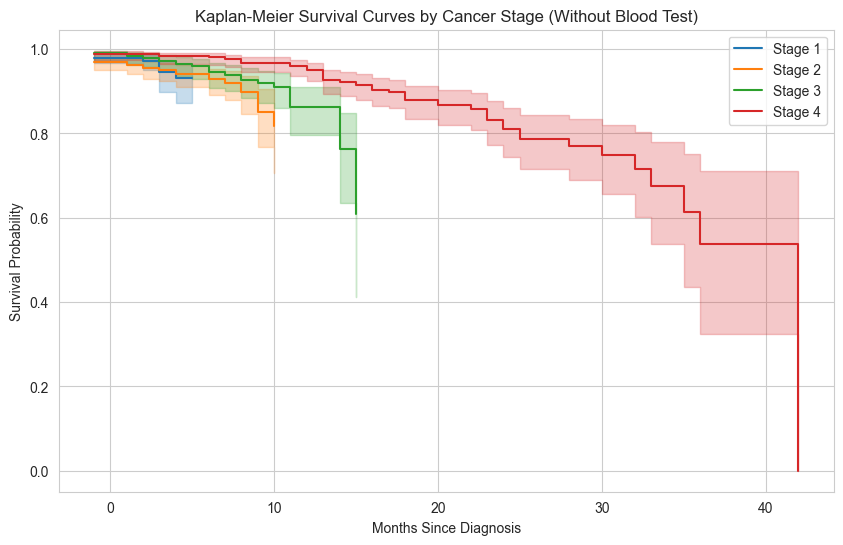

In [4]:
# plot competing risks for each stage
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test

# Create a Kaplan-Meier plot for each stage
fig, ax = plt.subplots(figsize=(10, 6))
kmf = KaplanMeierFitter()

for stage in range(1, 5):
    data = df_without_test[df_without_test['origin_state'] == stage]
    kmf.fit(data['months_since_diagnosis'], event_observed=data['target_state'] == 5, label=f'Stage {stage}')
    kmf.plot(ax=ax)
    
plt.title('Kaplan-Meier Survival Curves by Cancer Stage (Without Blood Test)')
plt.xlabel('Months Since Diagnosis')
plt.ylabel('Survival Probability')
plt.show()

In [5]:
proportions

NameError: name 'proportions' is not defined

/var/folders/83/3rjtktqn35l707cfgjnfh8xh0000gn/T/ipykernel_83846/2927411684.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aligned_df = df.groupby('sample_id').apply(adjust_time).reset_index(drop=True)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

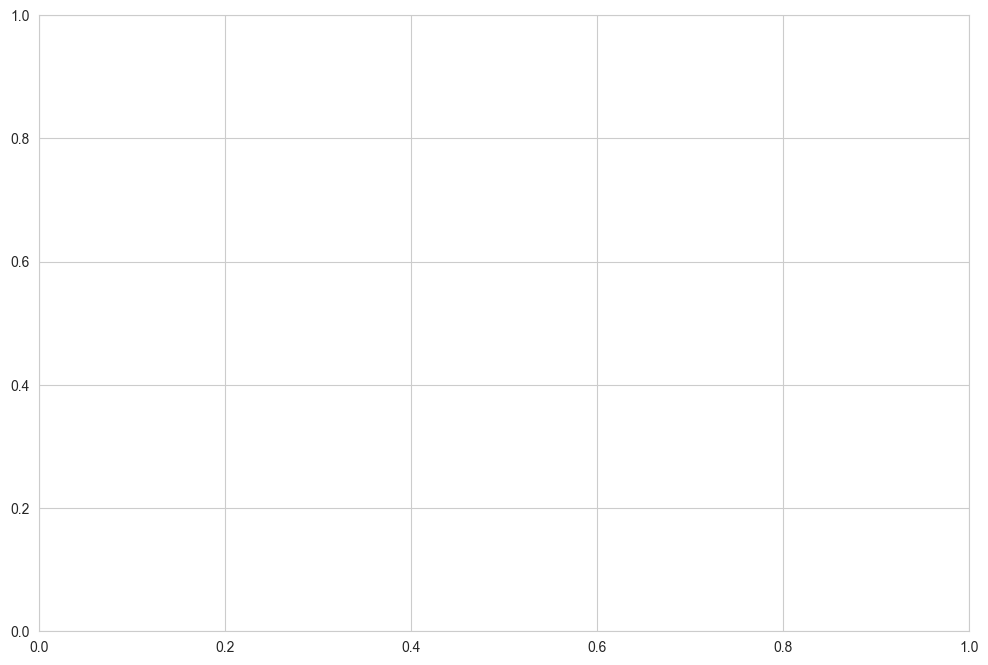

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def align_to_diagnosis(df):
    # Group by patient and find the diagnosis point
    diagnosis_points = df[df['months_since_diagnosis'] == 0].groupby('sample_id')['time_entry_to_origin'].first()
    
    # Function to adjust time for each patient
    def adjust_time(group):
        patient_id = group['sample_id'].iloc[0]
        diagnosis_time = diagnosis_points.get(patient_id, np.inf)
        group['adjusted_time'] = group['time_entry_to_origin'] - diagnosis_time
        return group

    # Apply the adjustment to each patient's trajectory
    aligned_df = df.groupby('sample_id').apply(adjust_time).reset_index(drop=True)
    
    # Filter out pre-diagnosis data points and any rows with inf values
    aligned_df = aligned_df[(aligned_df['adjusted_time'] >= 0) & (aligned_df['adjusted_time'] != np.inf)]
    
    # Check that patient was diagnosed
    diagnosed_patients = aligned_df[aligned_df['months_since_diagnosis'] == 0]['sample_id'].unique()
    aligned_df = aligned_df[aligned_df['sample_id'].isin(diagnosed_patients)]
    
    return aligned_df

def create_stacked_area_chart(df, title):
    # Align data to diagnosis point
    aligned_df = align_to_diagnosis(df)
    
    # Ensure all columns are numeric
    for col in aligned_df.columns:
        if aligned_df[col].dtype == 'object':
            aligned_df[col] = pd.to_numeric(aligned_df[col], errors='coerce')
    
    # Remove any rows with NaN values
    aligned_df = aligned_df.dropna()
    
    # Process the aligned data
    time_points = sorted(aligned_df['adjusted_time'].unique())
    states = sorted(aligned_df['target_state'].unique())
    
    initial_states_count = len(aligned_df[aligned_df['adjusted_time'] == 0]['target_state'])
    # Create a DataFrame to hold the proportions
    proportions = pd.DataFrame(index=time_points, columns=states)
    
    # Calculate proportions for each state at each time point
    for time in time_points:
        time_slice = aligned_df[aligned_df['adjusted_time'] == time]
        state_counts = time_slice['target_state'].value_counts()
        total = len(time_slice['sample_id'].unique())
        # for the difference between current total and initial total, fill with state 5 (death)
        diff = initial_states_count - total
        if diff > 0:
            state_counts[5] = state_counts.get(5, 0) + diff
        for state in states:
            proportions.loc[time, state] = state_counts.get(state, 0) / initial_states_count
            

    # Create the stacked area plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Custom color palette
    colors = plt.get_cmap('RdYlBu')(np.linspace(0.1, 0.9, len(states)))
    
    ax.stackplot(proportions.index, proportions.T, labels=states, colors=colors)
    
    # Customize the plot
    ax.set_xlabel('Time since diagnosis (months)')
    ax.set_ylabel('Proportion')
    ax.set_title(title)
    ax.legend(title='States', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlim(0, max(time_points))
    ax.set_ylim(0, 1)
    
    # Add gridlines
    ax.grid(True, alpha=0.3)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Assuming df_without_test and df_with_test are your DataFrames
create_stacked_area_chart(df_without_test, "Cancer Progression Without Blood Test")
create_stacked_area_chart(df_with_test, "Cancer Progression With Blood Test")

In [47]:
df = df_without_test
# Align data to diagnosis point
aligned_df = align_to_diagnosis(df)
aligned_df
# Process the aligned data
time_points = sorted(aligned_df['adjusted_time'].unique())
states = sorted(aligned_df['target_state'].unique())

initial_states_count = len(aligned_df[aligned_df['adjusted_time'] == 0]['target_state'])
# Create a DataFrame to hold the proportions
proportions = pd.DataFrame(index=time_points, columns=states)

# Calculate proportions for each state at each time point
for time in time_points:
    time_slice = aligned_df[aligned_df['adjusted_time'] == time]
    state_counts = time_slice['target_state'].value_counts()
    total = len(time_slice['sample_id'].unique())
    # for the difference between current total and initial total, fill with state 5 (death)
    diff = initial_states_count - total
    if diff > 0:
        state_counts[5] = state_counts.get(5, 0) + diff
    for state in states:
        proportions.loc[time, state] = state_counts.get(state, 0) / initial_states_count
proportions_without = proportions
proportions_without.to_csv('proportions_without.csv')

/var/folders/83/3rjtktqn35l707cfgjnfh8xh0000gn/T/ipykernel_83846/2927411684.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aligned_df = df.groupby('sample_id').apply(adjust_time).reset_index(drop=True)


In [48]:
df = df_with_test

aligned_df = align_to_diagnosis(df)
aligned_df
# Process the aligned data
time_points = sorted(aligned_df['adjusted_time'].unique())
states = sorted(aligned_df['target_state'].unique())

initial_states_count = len(aligned_df[aligned_df['adjusted_time'] == 0]['target_state'])
# Create a DataFrame to hold the proportions
proportions = pd.DataFrame(index=time_points, columns=states)

# Calculate proportions for each state at each time point
for time in time_points:
    time_slice = aligned_df[aligned_df['adjusted_time'] == time]
    state_counts = time_slice['target_state'].value_counts()
    total = len(time_slice['sample_id'].unique())
    # for the difference between current total and initial total, fill with state 5 (death)
    diff = initial_states_count - total
    if diff > 0:
        state_counts[5] = state_counts.get(5, 0) + diff
    for state in states:
        proportions.loc[time, state] = state_counts.get(state, 0) / initial_states_count
proportions_with= proportions
proportions_with.to_csv('proportions_with.csv')

/var/folders/83/3rjtktqn35l707cfgjnfh8xh0000gn/T/ipykernel_83846/2927411684.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aligned_df = df.groupby('sample_id').apply(adjust_time).reset_index(drop=True)


In [55]:
pd.to_numeric(proportions[''])

TypeError: arg must be a list, tuple, 1-d array, or Series

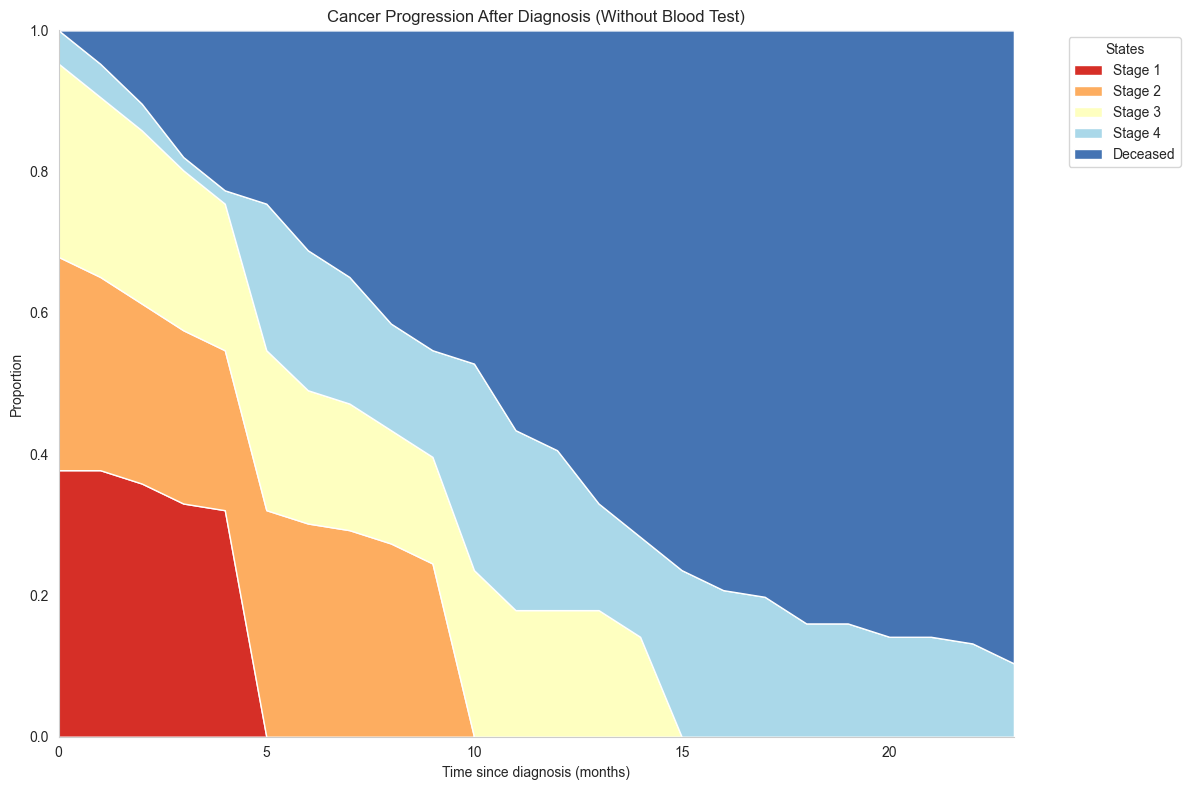

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import io

# Load the data
data = """
,1,2,3,4,5
0.0,0.37735849056603776,0.3018867924528302,0.27358490566037735,0.04716981132075472,0.0
1.0,0.37735849056603776,0.27358490566037735,0.25471698113207547,0.04716981132075472,0.04716981132075472
2.0,0.3584905660377358,0.25471698113207547,0.24528301886792453,0.03773584905660377,0.10377358490566038
3.0,0.330188679245283,0.24528301886792453,0.22641509433962265,0.018867924528301886,0.1792452830188679
4.0,0.32075471698113206,0.22641509433962265,0.20754716981132076,0.018867924528301886,0.22641509433962265
5.0,0.0,0.32075471698113206,0.22641509433962265,0.20754716981132076,0.24528301886792453
6.0,0.0,0.3018867924528302,0.18867924528301888,0.19811320754716982,0.3113207547169811
7.0,0.0,0.29245283018867924,0.1792452830188679,0.1792452830188679,0.3490566037735849
8.0,0.0,0.27358490566037735,0.16037735849056603,0.1509433962264151,0.41509433962264153
9.0,0.0,0.24528301886792453,0.1509433962264151,0.1509433962264151,0.4528301886792453
10.0,0.0,0.0,0.2358490566037736,0.29245283018867924,0.4716981132075472
11.0,0.0,0.0,0.1792452830188679,0.25471698113207547,0.5660377358490566
12.0,0.0,0.0,0.1792452830188679,0.22641509433962265,0.5943396226415094
13.0,0.0,0.0,0.1792452830188679,0.1509433962264151,0.6698113207547169
14.0,0.0,0.0,0.14150943396226415,0.14150943396226415,0.7169811320754716
15.0,0.0,0.0,0.0,0.2358490566037736,0.7641509433962265
16.0,0.0,0.0,0.0,0.20754716981132076,0.7924528301886793
17.0,0.0,0.0,0.0,0.19811320754716982,0.8018867924528302
18.0,0.0,0.0,0.0,0.16037735849056603,0.839622641509434
19.0,0.0,0.0,0.0,0.16037735849056603,0.839622641509434
20.0,0.0,0.0,0.0,0.14150943396226415,0.8584905660377359
21.0,0.0,0.0,0.0,0.14150943396226415,0.8584905660377359
22.0,0.0,0.0,0.0,0.1320754716981132,0.8679245283018868
23.0,0.0,0.0,0.0,0.10377358490566038,0.8962264150943396
24.0,0.0,0.0,0.0,0.08490566037735849,0.9150943396226415
25.0,0.0,0.0,0.0,0.0660377358490566,0.9339622641509434
26.0,0.0,0.0,0.0,0.0660377358490566,0.9339622641509434
27.0,0.0,0.0,0.0,0.0660377358490566,0.9339622641509434
28.0,0.0,0.0,0.0,0.05660377358490566,0.9433962264150944
29.0,0.0,0.0,0.0,0.05660377358490566,0.9433962264150944
30.0,0.0,0.0,0.0,0.04716981132075472,0.9528301886792453
31.0,0.0,0.0,0.0,0.04716981132075472,0.9528301886792453
32.0,0.0,0.0,0.0,0.03773584905660377,0.9622641509433962
33.0,0.0,0.0,0.0,0.02830188679245283,0.9716981132075472
34.0,0.0,0.0,0.0,0.02830188679245283,0.9716981132075472
35.0,0.0,0.0,0.0,0.018867924528301886,0.9811320754716981
36.0,0.0,0.0,0.0,0.009433962264150943,0.9905660377358491
37.0,0.0,0.0,0.0,0.009433962264150943,0.9905660377358491
38.0,0.0,0.0,0.0,0.009433962264150943,0.9905660377358491
39.0,0.0,0.0,0.0,0.009433962264150943,0.9905660377358491
40.0,0.0,0.0,0.0,0.009433962264150943,0.9905660377358491
41.0,0.0,0.0,0.0,0.009433962264150943,0.9905660377358491
42.0,0.0,0.0,0.0,0.0,1.0


"""

# Convert the string data to a DataFrame
df = pd.read_csv(io.StringIO(data), header=None, index_col=0)
df.columns = ['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Deceased']

# Create the stacked area plot
fig, ax = plt.subplots(figsize=(12, 8))

df = df.iloc[:25]

# Custom color palette
colors = plt.get_cmap('RdYlBu')(np.linspace(0.1, 0.9, len(df.columns)))

ax.stackplot(df.index, df.T, labels=df.columns, colors=colors)

# Customize the plot
ax.set_xlabel('Time since diagnosis (months)')
ax.set_ylabel('Proportion')
ax.set_title('Cancer Progression After Diagnosis (Without Blood Test)')
ax.legend(title='States', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlim(0, df.index.max())
ax.set_ylim(0, 1)

# Add gridlines
ax.grid(True, alpha=0.3)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

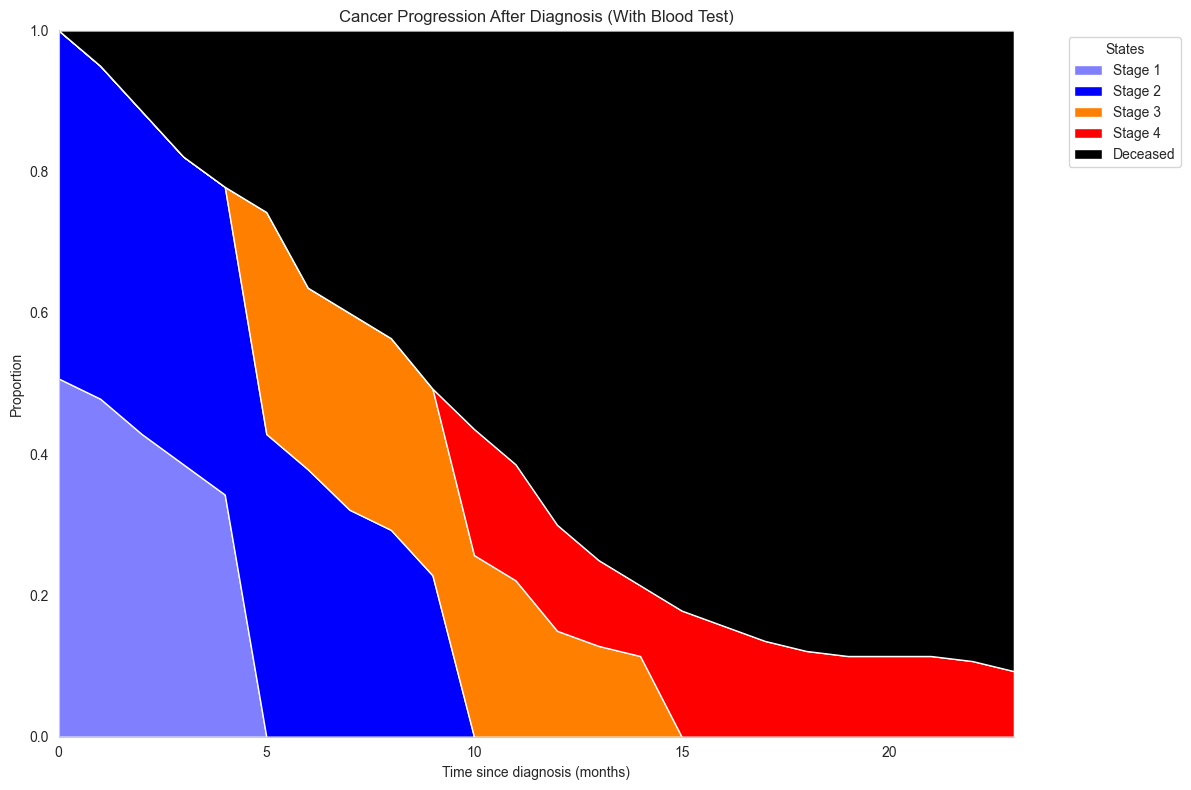

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import io

# Load the data
data = """
,1,2,3,4,5
0.0,0.5071428571428571,0.4928571428571429,0.0,0.0,0.0
1.0,0.4785714285714286,0.4714285714285714,0.0,0.0,0.05
2.0,0.42857142857142855,0.45714285714285713,0.0,0.0,0.11428571428571428
3.0,0.38571428571428573,0.4357142857142857,0.0,0.0,0.17857142857142858
4.0,0.34285714285714286,0.4357142857142857,0.0,0.0,0.22142857142857142
5.0,0.0,0.42857142857142855,0.3142857142857143,0.0,0.2571428571428571
6.0,0.0,0.37857142857142856,0.2571428571428571,0.0,0.36428571428571427
7.0,0.0,0.32142857142857145,0.2785714285714286,0.0,0.4
8.0,0.0,0.29285714285714287,0.2714285714285714,0.0,0.4357142857142857
9.0,0.0,0.22857142857142856,0.2642857142857143,0.0,0.5071428571428571
10.0,0.0,0.0,0.2571428571428571,0.17857142857142858,0.5642857142857143
11.0,0.0,0.0,0.22142857142857142,0.16428571428571428,0.6142857142857143
12.0,0.0,0.0,0.15,0.15,0.7
13.0,0.0,0.0,0.12857142857142856,0.12142857142857143,0.75
14.0,0.0,0.0,0.11428571428571428,0.1,0.7857142857142857
15.0,0.0,0.0,0.0,0.17857142857142858,0.8214285714285714
16.0,0.0,0.0,0.0,0.15714285714285714,0.8428571428571429
17.0,0.0,0.0,0.0,0.1357142857142857,0.8642857142857143
18.0,0.0,0.0,0.0,0.12142857142857143,0.8785714285714286
19.0,0.0,0.0,0.0,0.11428571428571428,0.8857142857142857
20.0,0.0,0.0,0.0,0.11428571428571428,0.8857142857142857
21.0,0.0,0.0,0.0,0.11428571428571428,0.8857142857142857
22.0,0.0,0.0,0.0,0.10714285714285714,0.8928571428571429
23.0,0.0,0.0,0.0,0.09285714285714286,0.9071428571428571
24.0,0.0,0.0,0.0,0.07857142857142857,0.9214285714285714
25.0,0.0,0.0,0.0,0.05,0.95
26.0,0.0,0.0,0.0,0.05,0.95
27.0,0.0,0.0,0.0,0.05,0.95
28.0,0.0,0.0,0.0,0.03571428571428571,0.9642857142857143
29.0,0.0,0.0,0.0,0.02857142857142857,0.9714285714285714
30.0,0.0,0.0,0.0,0.02857142857142857,0.9714285714285714
31.0,0.0,0.0,0.0,0.02142857142857143,0.9785714285714285
32.0,0.0,0.0,0.0,0.02142857142857143,0.9785714285714285
33.0,0.0,0.0,0.0,0.014285714285714285,0.9857142857142858
34.0,0.0,0.0,0.0,0.014285714285714285,0.9857142857142858
35.0,0.0,0.0,0.0,0.014285714285714285,0.9857142857142858
36.0,0.0,0.0,0.0,0.014285714285714285,0.9857142857142858
37.0,0.0,0.0,0.0,0.014285714285714285,0.9857142857142858
38.0,0.0,0.0,0.0,0.014285714285714285,0.9857142857142858
39.0,0.0,0.0,0.0,0.014285714285714285,0.9857142857142858
40.0,0.0,0.0,0.0,0.007142857142857143,0.9928571428571429
41.0,0.0,0.0,0.0,0.007142857142857143,0.9928571428571429
42.0,0.0,0.0,0.0,0.007142857142857143,0.9928571428571429
43.0,0.0,0.0,0.0,0.007142857142857143,0.9928571428571429
44.0,0.0,0.0,0.0,0.007142857142857143,0.9928571428571429
45.0,0.0,0.0,0.0,0.007142857142857143,0.9928571428571429
46.0,0.0,0.0,0.0,0.007142857142857143,0.9928571428571429
47.0,0.0,0.0,0.0,0.0,1.0

"""

# Convert the string data to a DataFrame
df = pd.read_csv(io.StringIO(data), header=None, index_col=0)
df.columns = ['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Deceased']

# Create the stacked area plot
fig, ax = plt.subplots(figsize=(12, 8))

# cut off at 24 months
df = df.iloc[:25]

# Custom color palette
colors = plt.get_cmap('RdYlBu')(np.linspace(0.1, 0.9, len(df.columns)))

# for colors use lighter blue for stage 1, blue for stage 2, orange for stage 3, red for stage 4, black for deceased

colors = plt.get_cmap('RdYlBu')(np.linspace(0.1, 0.9, len(df.columns)))
colors[0] = (0.5, 0.5, 1, 1)
colors[1] = (0, 0, 1, 1)
colors[2] = (1, 0.5, 0, 1)
colors[3] = (1, 0, 0, 1)
colors[4] = (0, 0, 0, 1)

ax.stackplot(df.index, df.T, labels=df.columns, colors=colors)

# Customize the plot
ax.set_xlabel('Time since diagnosis (months)')
ax.set_ylabel('Proportion')
ax.set_title('Cancer Progression After Diagnosis (With Blood Test)')
ax.legend(title='States', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlim(0, df.index.max())
ax.set_ylim(0, 1)

# Add gridlines
ax.grid(True, alpha=0.3)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()